# Nepal Earthquake

### Import Libraries and Set Data Source 

In [27]:
import warnings
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import zipfile
from category_encoders import OneHotEncoder
from IPython.display import VimeoVideo
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.utils.validation import check_is_fitted

In [4]:
import sqlite3
%load_ext sql
%sql sqlite:///nepalDB.db

In [5]:
%%sql
select * from id_map limit 5

 * sqlite:///nepalDB.db
Done.


household_id,district_id,vdcmun_id,building_id
12010100001101,12,1207,1
12010100002101,12,1207,2
12010100003101,12,1207,3
12010100004101,12,1207,4
12010100005101,12,1207,5


### Prepare Data

In [6]:
%%sql
select distinct (district_id) from id_map

 * sqlite:///nepalDB.db
Done.


district_id
12
20
21
22
23
24
28
29
30
31


In [7]:
%sql select count(distinct(building_id)) from id_map

 * sqlite:///nepalDB.db
Done.


count(distinct(building_id))
747365


In [11]:
%%sql
SELECT DISTINCT im.building_id AS b_id,
    bs.*,
    bd.damage_grade
  FROM temp_map1 tm
       JOIN
       building_structure AS bs ON tm.building_id = bs.building_id
       JOIN 
       building_damage AS bd ON tm.building_id = bd.building_id
       JOIN
       id_map AS im ON im.household_id =tm.household_id 
       where im.district_id=36
        limit 5



 * sqlite:///nepalDB.db
Done.


b_id,building_id,district_id,vdcmun_id,ward_id,count_floors_pre_eq,count_floors_post_eq,age_building,plinth_area_sq_ft,height_ft_pre_eq,height_ft_post_eq,land_surface_condition,foundation_type,roof_type,ground_floor_type,other_floor_type,position,plan_configuration,condition_post_eq,superstructure,damage_grade
671455,360101000011,36,3609,360903,1,0,40,336,6,0,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,Not applicable,Not attached,Rectangular,0,1,Grade 5
671456,360101000021,36,3609,360903,2,2,12,420,13,13,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,TImber/Bamboo-Mud,Not attached,Rectangular,0,1,Grade 3
671457,360101000031,36,3609,360903,3,3,20,560,18,18,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,TImber/Bamboo-Mud,Not attached,Rectangular,0,1,Grade 2
671458,360101000041,36,3609,360903,2,2,15,390,12,12,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,TImber/Bamboo-Mud,Not attached,Rectangular,0,1,Grade 4
671459,360101000051,36,3609,360903,2,2,15,290,13,13,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,TImber/Bamboo-Mud,Not attached,Square,0,1,Grade 4


In [44]:
def wrangle(filepath):
    con= sqlite3.connect(filepath)
    
     # Construct query
    query = """
        SELECT DISTINCT im.building_id AS b_id,
    bs.*,
    bd.damage_grade
  FROM temp_map1 tm
       JOIN
       building_structure AS bs ON tm.building_id = bs.building_id
       JOIN 
       building_damage AS bd ON tm.building_id = bd.building_id
       JOIN
       id_map AS im ON im.household_id =tm.household_id 
       where im.district_id=36
    """
    
    #Read Query results into df
    df= pd.read_sql(query, con, index_col='b_id')
    
    #List post_eq data data
    drop_cols=[col for col in df.columns if 'post_eq' in col]
    
    #binary classification
    df['damage_grade']=df['damage_grade'].str.split(' ',expand=True)[1].astype(int)
    df['severity']=(df['damage_grade']>3).astype(int)
    
    #Drop cols for binary classification
    drop_cols.append('damage_grade')
    
    #Drop cols for leakage/non relevance
    drop_cols.append('building_id')
    drop_cols.append('district_id')
    drop_cols.append('vdcmun_id')
    drop_cols.append('ward_id')
    
    #Drop cols
    df.drop(columns=drop_cols, inplace=True)
    
    return df


In [45]:
df=wrangle('./nepalDB.db')
df.head()

,count_floors_pre_eq,age_building,plinth_area_sq_ft,height_ft_pre_eq,land_surface_condition,foundation_type,roof_type,ground_floor_type,other_floor_type,position,plan_configuration,superstructure,severity
b_id,,,,,,,,,,,,,
671455,1,40,336,6,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,Not applicable,Not attached,Rectangular,1,1
671456,2,12,420,13,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,TImber/Bamboo-Mud,Not attached,Rectangular,1,0
671457,3,20,560,18,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,TImber/Bamboo-Mud,Not attached,Rectangular,1,0
671458,2,15,390,12,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,TImber/Bamboo-Mud,Not attached,Rectangular,1,1
671459,2,15,290,13,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,TImber/Bamboo-Mud,Not attached,Square,1,1


In [50]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 75883 entries, 671455 to 747365
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   count_floors_pre_eq     75883 non-null  int64 
 1   age_building            75883 non-null  int64 
 2   plinth_area_sq_ft       75883 non-null  int64 
 3   height_ft_pre_eq        75883 non-null  int64 
 4   land_surface_condition  75883 non-null  object
 5   foundation_type         75883 non-null  object
 6   roof_type               75883 non-null  object
 7   ground_floor_type       75883 non-null  object
 8   other_floor_type        75883 non-null  object
 9   position                75883 non-null  object
 10  plan_configuration      75883 non-null  object
 11  superstructure          75883 non-null  object
 12  severity                75883 non-null  int32 
dtypes: int32(1), int64(4), object(8)
memory usage: 7.8+ MB


In [51]:
df['severity'].value_counts()

1    47885
0    27998
Name: severity, dtype: int64

### Explore

                     count_floors_pre_eq  age_building  plinth_area_sq_ft  \
count_floors_pre_eq             1.000000      0.054395           0.245652   
age_building                    0.054395      1.000000          -0.021963   
plinth_area_sq_ft               0.245652     -0.021963           1.000000   
height_ft_pre_eq                0.767730      0.035365           0.330765   

                     height_ft_pre_eq  
count_floors_pre_eq          0.767730  
age_building                 0.035365  
plinth_area_sq_ft            0.330765  
height_ft_pre_eq             1.000000  


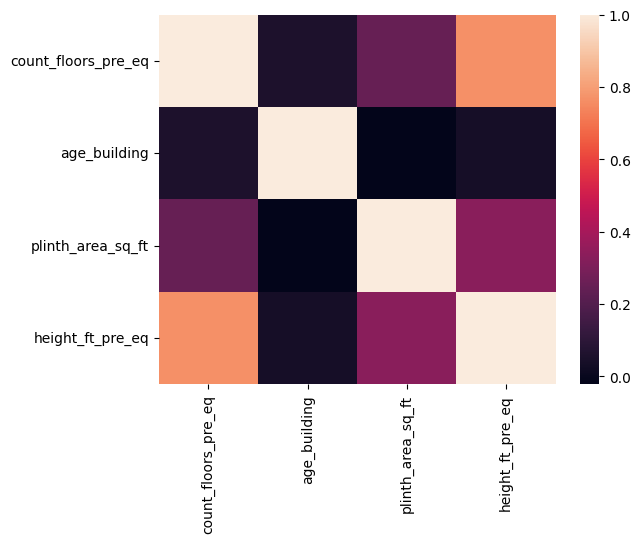

In [48]:
correlation=df.select_dtypes('number').drop(columns='severity').corr()
print(correlation)
sns.heatmap(correlation);

### Split

### Build Model

#### Baseline

#### Iterate

#### Evaluate

### Communicate